# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

## TBBB

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    

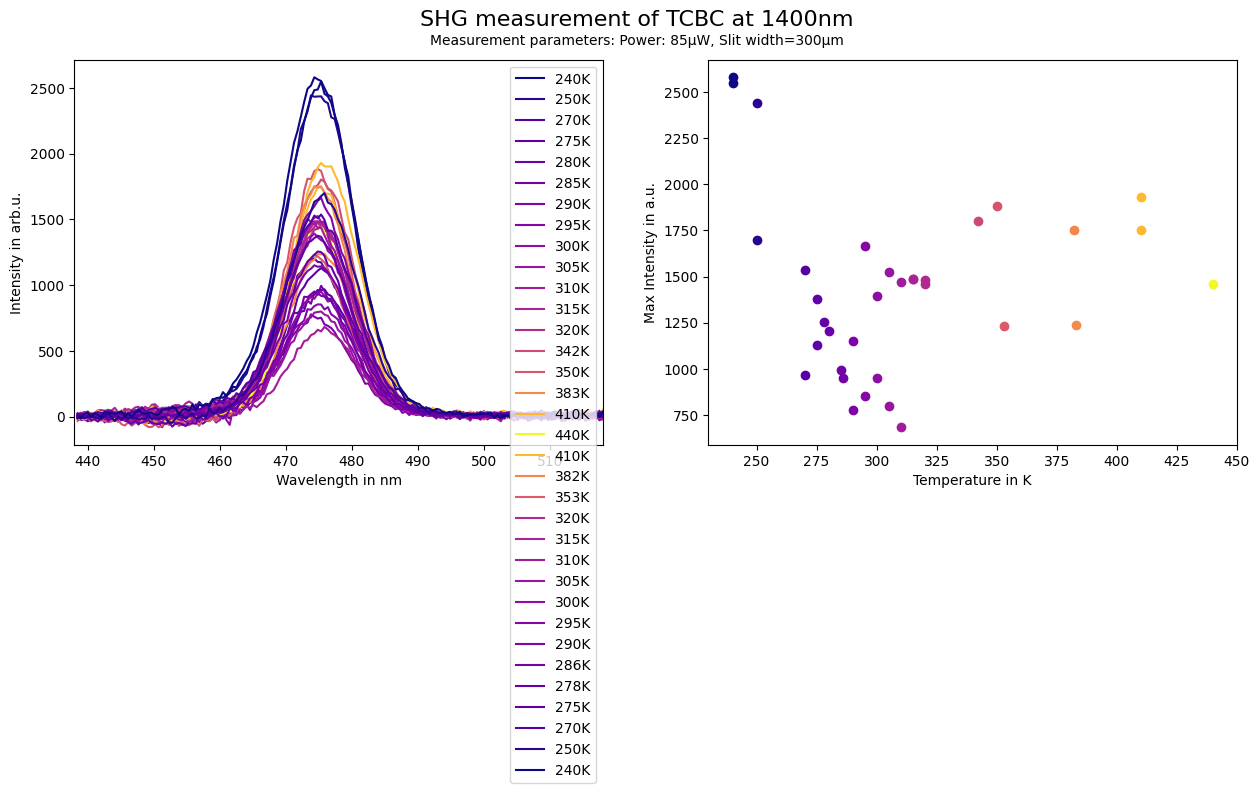

The maximum intensity across all temperatures is: 2580.0


In [37]:
# Define the range for the x-axis
middle_value = 478
difference = 40
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc')

def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val / 1 for val in intensities]
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx], label=f'{temperature}K')
    if filtered_intensities:
        peak_list.append(max(filtered_intensities))
        ax1.scatter(temperature, max(filtered_intensities), color=colors[idx])

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')
ax0.legend(loc='upper right')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('SHG measurement of TCBC at 1400nm', fontsize=16)
fig.text(0.5, 0.91, "Measurement parameters: Power: 85µW, Slit width=300µm", ha="center")
plt.show()
fig.savefig('./TCBC_SHG_ProofOfConcept.png', dpi=600, bbox_inches='tight')
fig.savefig('./TCBC_SHG_ProofOfConcept.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))